In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
import IPython.display as ipd

#import renamed libraries from the numerical toolbox
from local_signal import *
from general import *


In [2]:
def inpainting(image, p):
    """ 
    Given an image and a probability p, create a mask with p% of the pixels set to 0, and apply that mask to remove those pixels from the image.
    """
    mask = np.random.choice([0, 1], size=image.shape, p=[p, 1-p])
    return image * mask

def get_variance(snr, image, noise):
    """
    Function that computes the required variance of the noise to achieve a given SNR.
    """
    #get the norm of the image and the noise
    norm = np.linalg.norm(image)**2
    noise_norm = np.linalg.norm(noise)**2
    #compute the variance
    # variance = norm/(noise_norm*(np.exp((snr/10))))
    variance = norm/(noise_norm*(10**(snr/10)))
    return variance

def generate_noisy_image(snr, image):
    """ 
    Function that generates a noisy image with a given SNR.
    """
    noise = np.random.normal(0, 1, image.shape)
    variance = get_variance(snr, image, noise)
    sigma = np.sqrt(variance)
    noisy_image = image + noise * sigma
    return sigma, noisy_image

def compute_snr(image, noisy_image):
    """
    Function that computes the SNR between an image and a noisy image.
    """
    #get the norm of the image and the noise
    norm = np.linalg.norm(image)**2
    noise_norm = np.linalg.norm(noisy_image - image)**2
    #compute the SNR
    snr = 10*np.log10(norm/noise_norm)
    return snr

## Direct problem

$ x \in \mathbb{R}^N $ The signal of interest

$ A \in \mathbb{R}^{MN} $ a linear operator / matrix

$ y \in \mathbb{R}^M $ the noisy observed signal 

$ b \in \mathbb{R}^M $ be some gaussian white noise

the direct problem is:

$ y = Ax + b $

## Inverse problem

The goal is to estimate the original x from measurement y

if $ M \ge N $ then problem is overdetermined

if $ M \lt N $ then problem is underdetermined

## Denoising

$ A = Id_N $

$ y = x + n $

## Deconvolution

$ A $ is a Toeplitz matrix, or convolution matrix  ( $M \le N $)

$ y = Ax + n = h * x + n $

$ \hat{y} = \hat{h} \hat{x} + \hat{n} $

## Compressive sensing

$ A $ is a random matrix (with $ M \lt N $)

$ x = argmin \mathcal{L}(y, A, x) + \lambda \mathcal{R}(x) $

where

$ \mathcal{L}(y,A,x) $ is the loss: models the link between the signal $ x $ and the observation $ y $ through the operator $A$

$\mathcal{R}(x) $ is the loss: models the "prior"  on the signal $x$

$ \lambda \gt 0 $ is some hyperparameter



## Loss

$ \frac{1}{2} ||y-Ax||^2_n $ : energy of the residual, adapted to white gaussian noise $ 

$ \frac{1}{2} ||y-Ax||_1$ : robust regression

## Regularization

$ \frac{1}{2} ||x||^2_n $ : Energy on the signal

$ \frac{1}{2} ||\nabla x ||^2_n $: energy of the derivative

$ ||x||_1 $ : sparsity of the signal

$ || \nabla x||_1 $: Sparsity of the derivative (total variation)

## Use of the dictionary

$ \mathcal{R}(x) $ can be difficult to choose

Idea: use a dictionary such as wavelets where the signal is known to be sparse (well represented by few coefficients)

Let $ \phi \in \mathbb{R}^{NK} $ be such a dictionary, with $ x = \phi\alpha, \alpha \in \mathbb{R}^K $ are called synthesis coefficients

Then, the direct problem becomes

$ y = A\phi\alpha + n $

And the min problem becomes

$ \alpha = argmin\frac{1}{2} ||y-A\phi\alpha||^2_2 + \lambda||\alpha||_1

and

$ x = \phi\alpha $


## How to minimize

$ \alpha = argmin \frac{1}{2} ||y - A\phi\alpha||^2_2 + \lambda ||\alpha||_1 $

It is a non-smooth convex problem

It is known as the Lasso or Basis Pursuit Denoising

## Proximal operator and soft thresholding

Consider the denoising case

$ \alpha = argmin \frac{1}{2}||y-\alpha||^2_2 + \lambda||\alpha||_1$

We can show that the solution is given by the so-called soft thresholding operator:

$\alpha = \mathcal{S}_\lambda (y) = y(1 - \frac{\lambda}{|y|})^{+} $

with $(x)^+ = max(0,x)$, and all the operations are applied coordinatewise.

## Fast Iterative Shrinkage / Thresholding algorithm (FISTA)

Initialization $ \alpha^{(0)} \in \mathbb{R}^N, z^{(0)} \in \mathbb{R}^N, L \le ||A\phi||^2, t=0$

Do until convergence

* $\alpha^{t+1} = \mathcal{S}_{\lambda/L}(z^{(t)} + \frac{1}{L}\phi*A*(y-A\phi z^{(t)}))$

* $z^{(t+1)} = \alpha^{(t+1)} + \frac{t}{t+5}(\alpha^{(t+1)} - \alpha^{(t)}) $

Remark: We have $||A\phi||^2 \le ||A||^2||\phi||^2$, then if $ \phi $ is a Parseval frame, we simply have $L \le ||A||^2$.

## Fast Iterative Shrinkage/Thresholding algorithm (FISTA) with warm restart

In practice, the algorithm must be run with various values of lambda.

When $ \lambda \rightarrow 0 $ we have $ |y - A\phi\alpha|\rightarrow 0$.

When $ \lambda = ||\phi*A*y||_{\infty} $, the solution is $\alpha=0$

One can choose these values distributed on a log scale in $ \in [10^{-4} ||\phi*A*y||_\infty, ||\phi*A*y||_\infty)$, with a fixed number of $\lambda$, such as we have $\lambda_1 \gt \lambda_2 \gt ... \gt \lambda_I$

The idea is to initialize the algorithm for $\lambda_i$ with the results we get from $\lambda_{i-1}$

Set $L \le ||A\phi||^2 $ and $\alpha_{(0)} = z_{(0)} = 0 $

for $i = 1 : I$

* Choose $ \lambda = \lambda_i $

* Initialize $\alpha^{(0)}_{(i)} = \alpha_{(i-1)}, t=0$

* Do until convergence:

$ \alpha^{(t+1)}_{(i)} = \mathcal{S}_{\lambda/L}(z^{(t)}_{(i)}+\frac{1}{L}\phi*A*(y-A\phi z^{(t)}_{(i)})) $

$z^{(t+1)}_{(i)} = \alpha^{(t+1)}_{(i)} + \frac{t}{t+5}(\alpha^{(t+1)}_{(i)} - \alpha^{(t)}_{(i)}) $

## Thresholding rules

The soft-thresholding can be replaced by any thresholding rules

Some examples:

* Hard thresholding $ \mathcal{H}_\lambda(\alpha) = \alpha \mathbb{1}_{|\alpha|\gt\lambda}$

* Empirical Wiener: $ \mathcal{S}^{EW}_\lambda(\alpha) = \alpha(1 - \frac{\lambda^2}{|\alpha|^2})^+$

(512, 512)


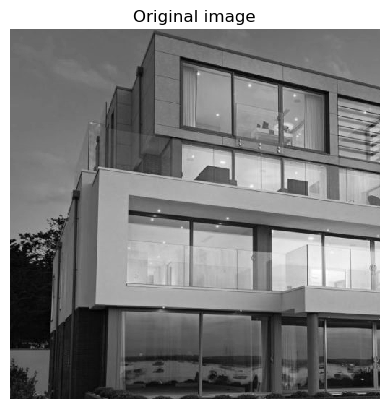

In [3]:
image = load_image('apartment.jpg')
#resize to 512x512
image = image[100:612, 100:612]
image_shape = image.shape
print(image.shape)

imageplot(image, "Original image")

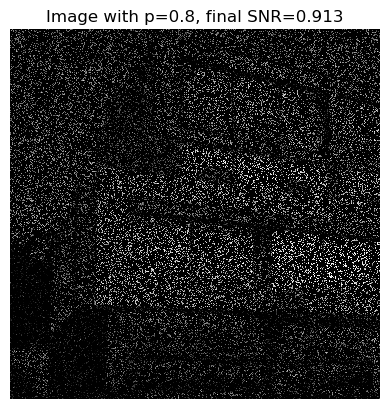

In [4]:
target_SNR = 13
noise_sigma, noisy_image = generate_noisy_image(target_SNR, image)
#imageplot(clamp(noisy_image), "Noisy, SNR=" + str(compute_snr(image, noisy_image)))

#perform inpainting with 0.7 probability
p = 0.8
inpainting_image = inpainting(noisy_image, p)
imageplot(clamp(inpainting_image), "Image with p=" + str(p) + ", final SNR=%.3f" %(compute_snr(image, inpainting_image)))

Text(0.5, 1.0, 'Wavelet coefficients')

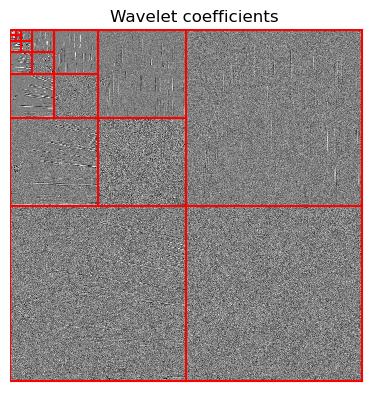

In [7]:
def thresh_soft(u,t):return np.maximum(1-t/abs(u), 0)*u
Jmin = 3
h = [0, .482962913145, .836516303738, .224143868042, -.129409522551]
a = perform_wavortho_transf(noisy_image,Jmin,+1,h)
T = 3/2*noise_sigma
aT = thresh_soft(a,T)
plot_wavelet(a,Jmin);
plt.title("Wavelet coefficients")

Text(0.5, 1.0, 'Thresholded coefficients')

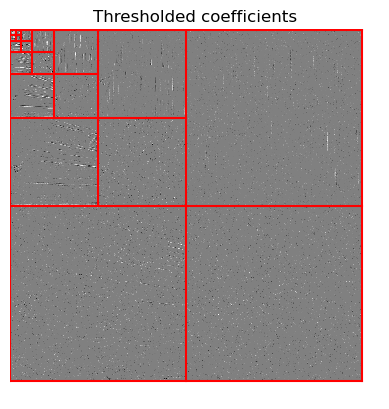

In [8]:
plot_wavelet(aT,Jmin);
plt.title("Thresholded coefficients")

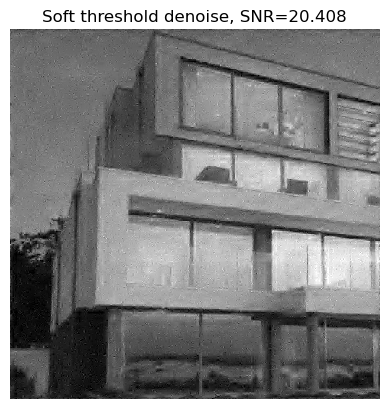

In [6]:
fHard = perform_wavortho_transf(aT,Jmin,-1,h)
imageplot(clamp(fHard), 'Soft threshold denoise, SNR=%.3f' %(snr(image,fHard)) )